In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
import sys
import pickle
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *
from torchvision.transforms import ToTensor, ToPILImage, Pad, Compose
from torchvision.utils import make_grid
from core.utils.CNN_scorers import resize_and_pad_tsr


In [5]:
# set path variabels
pd_key="expriment_meta_data_df"
proc_data_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\unit_inflation_smal_set"
rawdata_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\unit_inflation_smal_set\unit_inflation_small_set_081723"
save_root = os.path.join(r"N:\PonceLab\Users\Alireza\insilico_experiments\proto_img_sim_vs_activity")

os.makedirs(save_root, exist_ok=True)
concated_df_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_concated")
metadata_df_cosine = pd.read_hdf(os.path.join(concated_df_path, "meta_data_df.h5"), key=pd_key)
metadata_df_cosine.loc[metadata_df_cosine['modif_unit_id'].isnull(), 'exp_stage'] = 'reconstruction'

In [ ]:
metadata_df_cosine.columns


In [8]:
# let loa
layer_short= "conv5"
similarity_metric_list = ["MSE", "cosine"]
smpling_types = ["most", 'random']
pop_size = 128
gen_rerun_id_max = metadata_df_cosine["gen_rerun_id"].max()
pop_resampling_max = metadata_df_cosine["pop_resampling_id"].max()
image_name_list = metadata_df_cosine[(metadata_df_cosine["layer_short"] == layer_short)&\
                                      (metadata_df_cosine["pop_size"] == pop_size)]["trget_imge_name"].unique()


pro_image_type = "best_gen_imgs"
pop_act_evol_type = "popul_act_evol"
inflation_tragectory_type = "best_in_each_gen_imgs_RF_masked"

inflation_evol_data_type = "generation_data"

# set foint size
plt.rcParams.update({'font.size': 21})

# Load or create your matrix
metric_list = ['euclidean', 'cosine']  # Example metric in ['euclidean', 'correlation', 'cosine']


RF_treshold = 2
pop_resampling_id = 0
num_of_sample_to_print = 16
save_path_root = os.path.join(save_root, f"inflation_profile_{pop_size}_v3")

# load rsetive filed mask
rf_obj = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size}.npz"))

# setup the  GAN
gan_name = 'fc6'
Ngens = 100
num_gen = 100
##
sampling_type = smpling_types[0]
similarity_metric = 'MSE'
image_name = image_name_list[1]
gen_rerun_id = 0

In [ ]:

##

proto_list = list()
proto_score_list = list()
proto_unit_idx = list()
proto_gen_rerun_id = list()
proto_unit_real_id = list()
proto_image_idx_list = list()
proto_sampling_type_idx_list = list()
proto_image_namme_list = list()
proto_sampling_type_list = list()

proto_gen_idx = list()
units_proto_evol_codes = list()
units_proto_evol_score = np.zeros((pop_size, num_gen))
units_proto_evol_act_mat_list = list()
units_proto_evol_unit_idx = list()
units_proto_evol_gen_id = list()
units_proto_evol_gen_rerun_id = list()

for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        for gen_rerun_id in range(gen_rerun_id_max + 1):
            for ni in range(pop_size):
                '''inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                        output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                        similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                        pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                actmat_all = inflation_evol_data['actmat_all']
                generations = inflation_evol_data['generations']
                scores_all = inflation_evol_data['scores_all']
                best_code_all = inflation_evol_data['best_codes']
                units_proto_evol_codes.append(best_code_all)
                units_proto_evol_unit_idx.append(np.ones(num_gen) * ni)
                units_proto_evol_gen_id.append(np.arange(num_gen))
                units_proto_evol_gen_rerun_id.append(np.ones(num_gen) * gen_rerun_id)
                units_proto_evol_act_mat = np.zeros((num_gen, pop_size))
                for gi in range(num_gen):
                    scores_gen = scores_all[generations == gi]
                    actmat_gen = actmat_all[generations == gi, :]
                    max_score_index = scores_gen.argmax()
                    units_proto_evol_score_o[ni, gi] = scores_gen[max_score_index]
                    units_proto_evol_act_mat[gi, :] = actmat_gen[max_score_index, :]
                units_proto_evol_act_mat_list.append(units_proto_evol_act_mat)   
                # get cell prototypes'''
                unit_prtoptype = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                proto_score = column_inquary('score', metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                unit_real_id = column_inquary('modif_unit_id', metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=pro_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'inflation_from_scratch', modif_unit_idx=ni)
                proto_score_list.append(proto_score)
                proto_list.append(unit_prtoptype)
                proto_unit_idx.append(ni)
                proto_gen_rerun_id.append(gen_rerun_id)
                proto_unit_real_id.append(unit_real_id[1])
                proto_image_namme_list.append(image_name)
                proto_sampling_type_list.append(sampling_type)
                proto_sampling_type_idx_list.append(si)
                proto_image_idx_list.append(ii)
                

In [ ]:
# let save all the list ve generated
#np.savez(os.path.join(save_root, "pre_pros_list"), proto_list=proto_list, proto_score_list=proto_score_list, proto_unit_idx=proto_unit_idx,
#        proto_gen_rerun_id=proto_gen_rerun_id, proto_unit_real_id=proto_unit_real_id, proto_image_namme_list=proto_image_namme_list,
#        proto_sampling_type_list=proto_sampling_type_list, proto_sampling_type_idx_list=proto_sampling_type_idx_list, proto_image_idx_list=proto_image_idx_list)

In [6]:
# let load the data
save_path = os.path.join(save_root, "NPZ")
# load the data
proto_data = np.load(os.path.join(save_path,"pre_pros_list.npz"), allow_pickle=True)
proto_list = proto_data['proto_list']
proto_list = [x for x in proto_list]
proto_score_list = proto_data['proto_score_list']
proto_score_list = [x for x in proto_score_list]
proto_unit_idx = proto_data['proto_unit_idx']
proto_unit_idx = [x for x in proto_unit_idx]
proto_gen_rerun_id = proto_data['proto_gen_rerun_id']
proto_gen_rerun_id = [x for x in proto_gen_rerun_id]
proto_unit_real_id = proto_data['proto_unit_real_id']
proto_unit_real_id = [x for x in proto_unit_real_id]
proto_image_namme_list = proto_data['proto_image_namme_list']
proto_image_namme_list = [x for x in proto_image_namme_list]
proto_sampling_type_list = proto_data['proto_sampling_type_list']
proto_sampling_type_list = [x for x in proto_sampling_type_list]
proto_sampling_type_idx_list = proto_data['proto_sampling_type_idx_list']
proto_sampling_type_idx_list = [x for x in proto_sampling_type_idx_list]
proto_image_idx_list = proto_data['proto_image_idx_list']
proto_image_idx_list = [x for x in proto_image_idx_list]


In [9]:
recon_list = list()
target_list = list()
reccon_act_map_list = list()
recon_act_mat_last_gen_list = list()    
recon_pop_ids_list= list()
recon_gen_rerun_id = list()
recon_unit_real_id = list()
recon_image_idx_list = list()
recon_sampling_type_idx_list = list()
recon_image_namme_list = list()
recon_sampling_type_list = list()

target_type = "target_img"
gen_image_type = "best_gen_imgs"
for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        for gen_rerun_id in range(gen_rerun_id_max + 1):
                        
                        target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                    output_type=target_type, pop_size=pop_size,
                                    similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                    pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')

                        recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')

                        pop_act_evol = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=pop_act_evol_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
                        selected_pop = column_inquary('pop_unit_idx', metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=pop_act_evol_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')
                        inflation_evol_data = load_npz(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                output_type=inflation_evol_data_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                similarity_metric=similarity_metric, sub_pop_type=sampling_type,
                                                pop_resampling_id=pop_resampling_id, exp_stage = 'reconstruction')    
                        recon_best_code_all = inflation_evol_data['best_codes']
                        recon_generations = inflation_evol_data['generations']
                        recon_scores_all = inflation_evol_data['scores_all']
                        recon_actmat_all = inflation_evol_data['actmat_all']
                        recon_act_mat = np.zeros((num_gen, pop_size))
                        for gi in range(num_gen):
                            scores_gen = recon_scores_all[recon_generations == gi]
                            actmat_gen = recon_actmat_all[recon_generations == gi, :]
                            max_score_index = scores_gen.argmax()
                            recon_act_mat[gi, :] = actmat_gen[max_score_index, :]
                        
                        scores_gen = recon_scores_all[recon_generations == num_gen-1]
                        actmat_gen = recon_actmat_all[recon_generations == num_gen-1, :]
                        max_score_index = scores_gen.argmax()
                        last_gen_act_map = actmat_gen[max_score_index, :]
                        
                        reccon_act_map_list.append(recon_act_mat)
                        recon_list.append(recontruction_image)
                        target_list.append(target_image)
                        recon_pop_ids_list.append(selected_pop)
                        recon_gen_rerun_id.append(gen_rerun_id)
                        recon_unit_real_id.append(selected_pop)
                        recon_image_idx_list.append(ii)
                        recon_sampling_type_idx_list.append(si)
                        recon_image_namme_list.append(image_name)
                        recon_sampling_type_list.append(sampling_type)
                        recon_act_mat_last_gen_list.append(last_gen_act_map)


In [10]:
# make (N, 3, 224, 224) tensor of the prototypes using the proto_list
def apply_rf_mask(RF_filter, img):
        if len(img.shape) == 3:
                masked_img =\
                        (torch.from_numpy(np.absolute(RF_filter[None,:,:])) / RF_filter.max()) *\
                        img
        elif len(img.shape) == 4:
                masked_img =\
                (torch.from_numpy(np.absolute(RF_filter[None,None,:,:])) / RF_filter.max()) *\
        img
        else:
                raise ValueError("The shape of the input image is not correct")
        return masked_img
    
        
    
RF_filter = rf_obj["fitmap"]
proto_tensor = torch.stack(proto_list)
proto_tensor_masked = apply_rf_mask(RF_filter, proto_tensor)
proto_list_mask = [apply_rf_mask(RF_filter, img) for img in proto_list]
recon_list_masked = [apply_rf_mask(RF_filter, img) for img in recon_list]
target_list_masked = [apply_rf_mask(RF_filter, img) for img in target_list]



(-0.5, 1375.5, 459.5, -0.5)

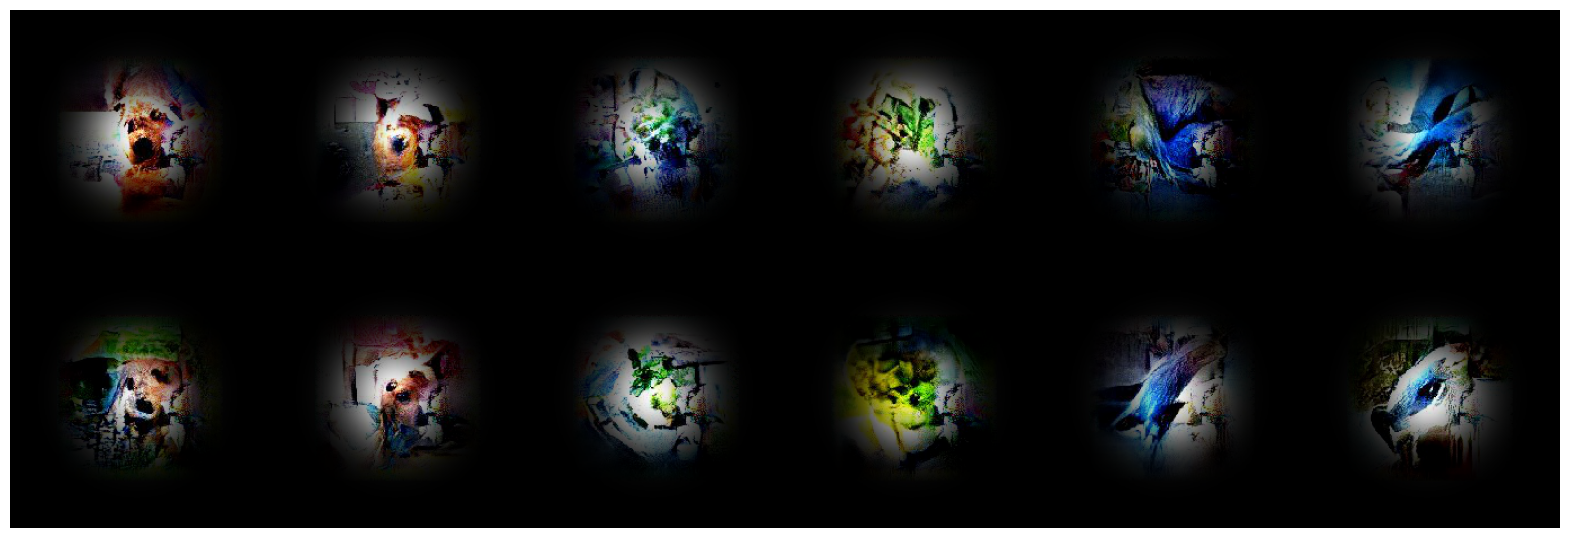

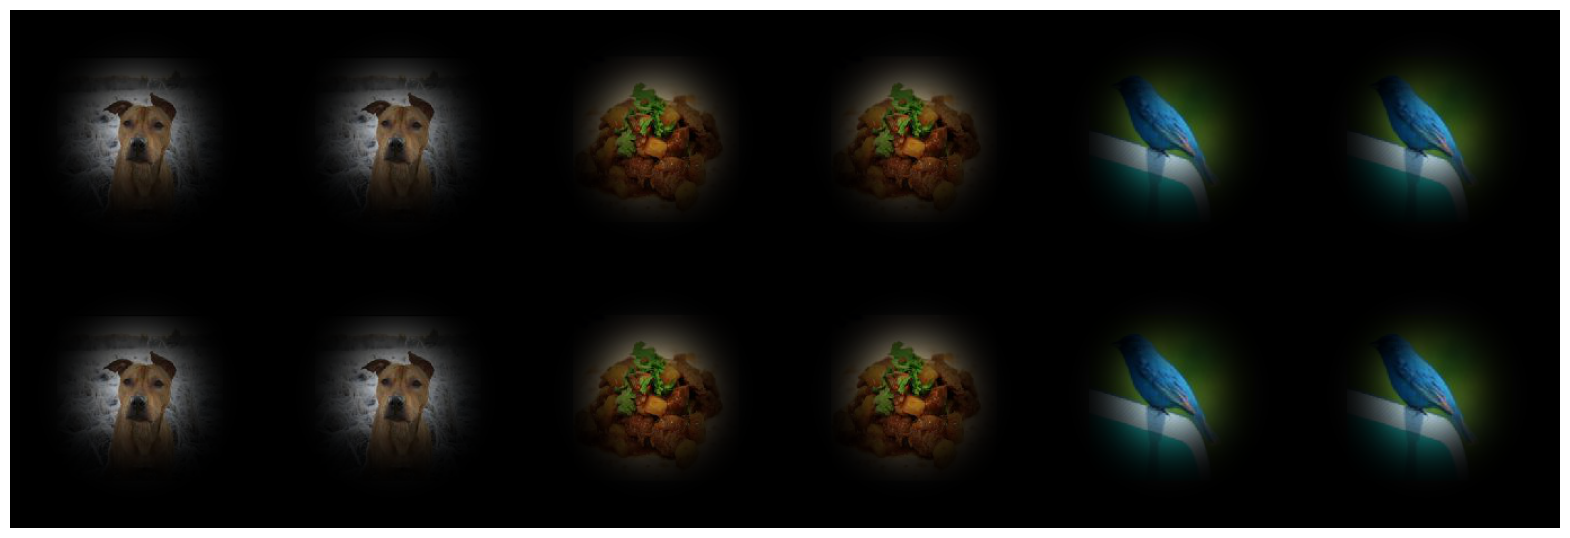

In [11]:
recon_list_masked_tensor = torch.stack(recon_list_masked)
target_list_masked_tensor = torch.stack(target_list_masked)
recon_grid = make_grid(recon_list_masked_tensor, nrow=6)
target_grid = make_grid(target_list_masked_tensor, nrow=6)
plt.figure(figsize=(20, 20))
plt.imshow(ToPILImage()(recon_grid))
plt.axis('off')

plt.figure(figsize=(20, 20))
plt.imshow(ToPILImage()(target_grid))
plt.axis('off')


In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(ToPILImage()(recon_list_masked[1]))
ax.axis('off')
ax.axis('off')
plt.show()

In [ ]:
'''## plot the prototypes and masked prototypes
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].imshow(ToPILImage()(proto_tensor[3]))
ax[0].set_title("Prototype")
ax[1].imshow(ToPILImage()(proto_tensor_masked[3]))
ax[1].set_title("Prototype masked")
ax[0].axis('off')
ax[1].axis('off')
plt.show()
## print the prototypes in a grid
proto_tensor_grid = make_grid(proto_tensor, nrow=25)
proto_tensor_masked_grid = make_grid(proto_tensor_masked, nrow=25)
plt.figure(figsize=(10, 10))
plt.imshow(ToPILImage()(proto_tensor_masked_grid))
plt.title("Prototypes")
plt.axis('off')'''

In [ ]:
recon_proto_similarities = list()
target_proto_similarities = list()
unit_act = list()
for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        recon_proto_similarities_gen_reeun = list()
        target_proto_similarities_gen_rerun = list()
        unit_act_gen_rerun = list()
        for gen_rerun_id in range(gen_rerun_id_max + 1):
            recon_idx = np.where((np.array(recon_image_namme_list) == image_name) &\
                                                    (np.array(recon_sampling_type_list) == sampling_type) &\
                                                    (np.array(recon_gen_rerun_id) == gen_rerun_id))[0][0]
            selected_pop = recon_pop_ids_list[recon_idx]
            selected_pop = selected_pop['.features.Conv2d10']
            slected_act_mat = recon_act_mat_last_gen_list[recon_idx]
            this_recon_proto = list()
            this_recon_act_mat = list()
            for ruidx, rui in enumerate(selected_pop):
                unit_selected_proto_idx = np.where(np.array(proto_unit_real_id)==rui)[0]
                this_unit_proto = [proto_list_mask[pri] for pri in unit_selected_proto_idx] # you can do eather masked or unmasked
                this_recon_act_mat.extend(np.repeat(slected_act_mat[ruidx], len(this_unit_proto), axis=0))
                this_recon_proto.extend(this_unit_proto)
            this_recon_proto_tensor = torch.stack(this_recon_proto)
            this_recon_recon_imge = recon_list_masked[recon_idx]
            this_recon_target_imge = target_list_masked[recon_idx]

            distance_proto_target = compute_l2_distance(this_recon_target_imge, this_recon_proto_tensor)
            distance_proto_recon = compute_l2_distance(this_recon_recon_imge, this_recon_proto_tensor)

            recon_proto_similarities_gen_reeun.append(-distance_proto_recon)
            target_proto_similarities_gen_rerun.append(-distance_proto_target)
            unit_act_gen_rerun.append(this_recon_act_mat)
        recon_proto_similarities_gen_reeun = np.stack(recon_proto_similarities_gen_reeun, axis=1)
        target_proto_similarities_gen_rerun = np.stack(target_proto_similarities_gen_rerun, axis=1)
        unit_act_gen_rerun = np.stack(unit_act_gen_rerun, axis=1)
        recon_proto_similarities.extend(np.mean(recon_proto_similarities_gen_reeun, axis=1))
        target_proto_similarities.extend(np.mean(target_proto_similarities_gen_rerun, axis=1))
        unit_act.extend(np.mean(unit_act_gen_rerun, axis=1))



In [ ]:
recon_proto_similarities = list()
target_proto_similarities = list()
unit_act = list()
for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        recon_proto_similarities_gen_reeun = list()
        target_proto_similarities_gen_rerun = list()
        unit_act_gen_rerun = list()
        for gen_rerun_id in range(gen_rerun_id_max + 1):
            recon_idx = np.where((np.array(recon_image_namme_list) == image_name) &\
                                                    (np.array(recon_sampling_type_list) == sampling_type) &\
                                                    (np.array(recon_gen_rerun_id) == gen_rerun_id))[0][0]
            selected_pop = recon_pop_ids_list[recon_idx]
            selected_pop = selected_pop['.features.Conv2d10']
            slected_act_mat = recon_act_mat_last_gen_list[recon_idx]
            this_recon_proto = list()
            this_recon_act_mat = list()
            for ruidx, rui in enumerate(selected_pop):
                unit_selected_proto_idx = np.where(np.array(proto_unit_real_id)==rui)[0]
                this_unit_proto = [proto_list_mask[pri] for pri in unit_selected_proto_idx] # you can do eather masked or unmasked
                this_recon_act_mat.extend(np.repeat(slected_act_mat[ruidx], len(this_unit_proto), axis=0))
                this_recon_proto.extend(this_unit_proto)
            this_recon_proto_tensor = torch.stack(this_recon_proto)
            this_recon_recon_imge = recon_list_masked[recon_idx]
            this_recon_target_imge = target_list_masked[recon_idx]

            distance_proto_target = compute_mse(this_recon_target_imge, this_recon_proto_tensor)
            distance_proto_recon = compute_mse(this_recon_recon_imge, this_recon_proto_tensor)

            recon_proto_similarities_gen_reeun.append(-distance_proto_recon)
            target_proto_similarities_gen_rerun.append(-distance_proto_target)
            unit_act_gen_rerun.append(this_recon_act_mat)
        recon_proto_similarities_gen_reeun = np.stack(recon_proto_similarities_gen_reeun, axis=1)
        target_proto_similarities_gen_rerun = np.stack(target_proto_similarities_gen_rerun, axis=1)
        unit_act_gen_rerun = np.stack(unit_act_gen_rerun, axis=1)
        recon_proto_similarities.extend(np.mean(recon_proto_similarities_gen_reeun, axis=1))
        target_proto_similarities.extend(np.mean(target_proto_similarities_gen_rerun, axis=1))
        unit_act.extend(np.mean(unit_act_gen_rerun, axis=1))


In [ ]:
recon_proto_similarities = list()
target_proto_similarities = list()
unit_act = list()
for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        recon_proto_similarities_gen_reeun = list()
        target_proto_similarities_gen_rerun = list()
        unit_act_gen_rerun = list()
        for gen_rerun_id in range(gen_rerun_id_max + 1):
            recon_idx = np.where((np.array(recon_image_namme_list) == image_name) &\
                                                    (np.array(recon_sampling_type_list) == sampling_type) &\
                                                    (np.array(recon_gen_rerun_id) == gen_rerun_id))[0][0]
            selected_pop = recon_pop_ids_list[recon_idx]
            selected_pop = selected_pop['.features.Conv2d10']
            slected_act_mat = recon_act_mat_last_gen_list[recon_idx]
            this_recon_proto = list()
            this_recon_act_mat = list()
            for ruidx, rui in enumerate(selected_pop):
                unit_selected_proto_idx = np.where(np.array(proto_unit_real_id)==rui)[0]
                this_unit_proto = [proto_list_mask[pri] for pri in unit_selected_proto_idx] # you can do eather masked or unmasked
                this_recon_act_mat.extend(np.repeat(slected_act_mat[ruidx], len(this_unit_proto), axis=0))
                this_recon_proto.extend(this_unit_proto)
            this_recon_proto_tensor = torch.stack(this_recon_proto).float()
            this_recon_recon_imge = recon_list_masked[recon_idx].float()
            this_recon_target_imge = target_list_masked[recon_idx].float()
            torch.cuda.empty_cache()
            distance_proto_target = compute_lpips_similarity_index(this_recon_target_imge, this_recon_proto_tensor).squeeze().detach().cpu()
            distance_proto_recon = compute_lpips_similarity_index(this_recon_recon_imge, this_recon_proto_tensor).squeeze().detach().cpu()

            recon_proto_similarities_gen_reeun.append(-distance_proto_recon)
            target_proto_similarities_gen_rerun.append(-distance_proto_target)
            unit_act_gen_rerun.append(this_recon_act_mat)
        recon_proto_similarities_gen_reeun = np.stack(recon_proto_similarities_gen_reeun, axis=1)
        target_proto_similarities_gen_rerun = np.stack(target_proto_similarities_gen_rerun, axis=1)
        unit_act_gen_rerun = np.stack(unit_act_gen_rerun, axis=1)
        recon_proto_similarities.extend(np.mean(recon_proto_similarities_gen_reeun, axis=1))
        target_proto_similarities.extend(np.mean(target_proto_similarities_gen_rerun, axis=1))
        unit_act.extend(np.mean(unit_act_gen_rerun, axis=1))

        '''
            recon_proto_similarities_gen_reeun.append(-distance_proto_recon)
            target_proto_similarities_gen_rerun.append(-distance_proto_target)
            unit_act_gen_rerun.append(this_recon_act_mat)
        recon_proto_similarities_gen_reeun = np.concatenate(recon_proto_similarities_gen_reeun, axis=0)
        target_proto_similarities_gen_rerun = np.concatenate(target_proto_similarities_gen_rerun, axis=0)
        unit_act_gen_rerun = np.concatenate(unit_act_gen_rerun, axis=0)
        recon_proto_similarities.extend(recon_proto_similarities_gen_reeun)
        target_proto_similarities.extend(target_proto_similarities_gen_rerun)
        unit_act.extend(unit_act_gen_rerun)'''


In [ ]:
# let use the observer network to get the similarity between the prototypes and the target image
from core.utils.CNN_scorers import TorchScorer
from core.utils.func_lib import *
from sklearn.metrics.pairwise import cosine_similarity

input_size = (3, 227, 227)

'''net_name = 'resnet50'
layer_list = ['.layer1.2.BatchNorm2dbn3', '.layer2.3.BatchNorm2dbn3', '.layer3.5.BatchNorm2dbn3', '.layer4.2.BatchNorm2dbn3']

net_name = 'resnet50_linf_8'
layer_list = ['.layer1.2.BatchNorm2dbn3', '.layer2.3.BatchNorm2dbn3', '.layer3.5.BatchNorm2dbn3', '.layer4.2.BatchNorm2dbn3']

net_name = 'cornet_s'
layer_list = ['.V1.BatchNorm2dnorm2', '.V2.BatchNorm2dnorm3_1', '.V4.BatchNorm2dnorm3_3', '.IT.BatchNorm2dnorm3_1']

net_name = 'alexnet'
layer_list = ['.features.Conv2d3', '.features.Conv2d6', '.features.Conv2d8', '.features.Conv2d10']
scorer = TorchScorer(net_name)
'''
net_name = 'cornet_s'
layer_list = ['.V1.BatchNorm2dnorm2', '.V2.BatchNorm2dnorm3_1', '.V4.BatchNorm2dnorm3_3', '.IT.BatchNorm2dnorm3_1']
scorer = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
    scorer.model, input_size, "cuda", False)
unit_mask_dict, unit_tsridx_dict = set_all_center_unit_population_recording(
                    scorer, layer_list)

recon_proto_similarities_mat = list()
target_proto_similarities_mat = list()
unit_act = list()
for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        recon_proto_similarities_gen_reeun = list()
        target_proto_similarities_gen_rerun = list()
        unit_act_gen_rerun = list()
        for gen_rerun_id in range(gen_rerun_id_max + 1):
            recon_idx = np.where((np.array(recon_image_namme_list) == image_name) &\
                                                    (np.array(recon_sampling_type_list) == sampling_type) &\
                                                    (np.array(recon_gen_rerun_id) == gen_rerun_id))[0][0]
            selected_pop = recon_pop_ids_list[recon_idx]
            selected_pop = selected_pop['.features.Conv2d10']
            slected_act_mat = recon_act_mat_last_gen_list[recon_idx]
            this_recon_proto = list()
            this_recon_act_mat = list()
            for ruidx, rui in enumerate(selected_pop):
                unit_selected_proto_idx = np.where(np.array(proto_unit_real_id)==rui)[0]
                this_unit_proto = [proto_list_mask[pri] for pri in unit_selected_proto_idx] # you can do eather masked or unmasked
                this_recon_act_mat.extend(np.repeat(slected_act_mat[ruidx], len(this_unit_proto), axis=0))
                this_recon_proto.extend(this_unit_proto)
            this_recon_proto_tensor = torch.stack(this_recon_proto).float()
            this_recon_recon_imge = recon_list_masked[recon_idx].float()
            this_recon_target_imge = target_list_masked[recon_idx].float()
            proto_encoded, _ = encode_image(scorer, this_recon_proto_tensor,  key=layer_list,
                                    RFresize=False, cat_layes=False)
            recon_encoded, _ = encode_image(scorer, this_recon_recon_imge.unsqueeze(0),  key=layer_list,
                                                RFresize=False, cat_layes=False)
            target_encoded, _ = encode_image(scorer, this_recon_target_imge.unsqueeze(0),  key=layer_list,
                                                RFresize=False, cat_layes=False)
            encoding_sim_recon_mat = list()
            encoding_sim_target_mat = list()
            for li in range(len(proto_encoded)):
                encoding_sim_recon_vec = np.mean(cosine_similarity(proto_encoded[li], recon_encoded[li]), axis=1)
                encoding_sim_target_vec = np.mean(cosine_similarity(proto_encoded[li], target_encoded[li]), axis=1)
                encoding_sim_recon_mat.append(encoding_sim_recon_vec)
                encoding_sim_target_mat.append(encoding_sim_target_vec)
            encoding_sim_recon_mat = np.stack(encoding_sim_recon_mat, axis=1)
            encoding_sim_target_mat = np.stack(encoding_sim_target_mat, axis=1)
            recon_proto_similarities_gen_reeun.append(encoding_sim_recon_mat)
            target_proto_similarities_gen_rerun.append(encoding_sim_target_mat)
            unit_act_gen_rerun.append(this_recon_act_mat)
        recon_proto_similarities_gen_reeun = np.stack(recon_proto_similarities_gen_reeun, axis=2)
        target_proto_similarities_gen_rerun = np.stack(target_proto_similarities_gen_rerun, axis=2)
        unit_act_gen_rerun = np.stack(unit_act_gen_rerun, axis=1)
        recon_proto_similarities_mat.append(np.mean(recon_proto_similarities_gen_reeun, axis=2))
        target_proto_similarities_mat.append(np.mean(target_proto_similarities_gen_rerun, axis=2))
        unit_act.append(np.mean(unit_act_gen_rerun, axis=1))  
recon_proto_similarities_mat = np.concatenate(recon_proto_similarities_mat, axis=0)
target_proto_similarities_mat = np.concatenate(target_proto_similarities_mat, axis=0)
unit_act = np.concatenate(unit_act, axis=0)
scorer.cleanup()
torch.cuda.empty_cache() 


In [22]:
import warnings
warnings.filterwarnings("ignore")

from core.utils.image_similarity import TorchImageDistance
img_dist_obj = TorchImageDistance()

recon_proto_similarities_l2 = list()
recon_proto_similarities_mse = list()
recon_proto_similarities_lpips = list()
recon_proto_similarities_CNN_cosine = list()
recon_proto_similarities_CNN_cosine_l1 = list()
recon_proto_similarities_CNN_cosine_l2 = list()
recon_proto_similarities_CNN_cosine_l3 = list()
recon_proto_similarities_CNN_cosine_l4 = list()


unit_act = list()
for si, sampling_type in enumerate(smpling_types):
    for ii, image_name in enumerate(image_name_list):
        recon_proto_similarities_gen_reeun_l2 = list()
        recon_proto_similarities_gen_reeun_mse = list()
        recon_proto_similarities_gen_reeun_lpips = list()
        recon_proto_similarities_gen_reeun_CNN_cosine = list()
        recon_proto_similarities_gen_reeun_CNN_cosine_l1 = list()
        recon_proto_similarities_gen_reeun_CNN_cosine_l2 = list()
        recon_proto_similarities_gen_reeun_CNN_cosine_l3 = list()
        recon_proto_similarities_gen_reeun_CNN_cosine_l4 = list()

        unit_act_gen_rerun = list()
        for gen_rerun_id in range(gen_rerun_id_max + 1):
            recon_idx = np.where((np.array(recon_image_namme_list) == image_name) &\
                                                    (np.array(recon_sampling_type_list) == sampling_type) &\
                                                    (np.array(recon_gen_rerun_id) == gen_rerun_id))[0][0]
            selected_pop = recon_pop_ids_list[recon_idx]
            selected_pop = selected_pop['.features.Conv2d10']
            slected_act_mat = recon_act_mat_last_gen_list[recon_idx]
            this_recon_proto = list()
            this_recon_act_mat = list()
            for ruidx, rui in enumerate(selected_pop):
                unit_selected_proto_idx = np.where(np.array(proto_unit_real_id)==rui)[0]
                this_unit_proto = [proto_list_mask[pri] for pri in unit_selected_proto_idx] # you can do eather masked or unmasked
                this_recon_act_mat.extend(np.repeat(slected_act_mat[ruidx], len(this_unit_proto), axis=0))
                this_recon_proto.extend(this_unit_proto)
            this_recon_proto_tensor = torch.stack(this_recon_proto).float()
            this_recon_recon_imge = recon_list_masked[recon_idx].float()
            img_dist_obj.set_first_image_batch(this_recon_proto_tensor)
            # extend the this_recon_recon_imge in the batch dimention with the number of prototypes
            this_recon_recon_imge = this_recon_recon_imge.repeat(this_recon_proto_tensor.shape[0], 1, 1, 1)
            img_dist_obj.set_second_image_batch(this_recon_recon_imge)

            l2_dist, _ = img_dist_obj.get_L2_distance()
            mse_dist,_ = img_dist_obj.get_MSE_distance()
            lpips_dist = img_dist_obj.get_LPIPS_distance()
            CNN_cosine_dist,CNN_cosine_dist_mat = img_dist_obj.get_CCN_distance(units_slice='center')
            CNN_cosine_dist_ly = np.mean(CNN_cosine_dist_mat, axis=(0))
            CNN_cosine_dist_l1 = CNN_cosine_dist_ly[0]
            CNN_cosine_dist_l2 = CNN_cosine_dist_ly[1]
            CNN_cosine_dist_l3 = CNN_cosine_dist_ly[2]
            CNN_cosine_dist_l4 = CNN_cosine_dist_ly[3]

            recon_proto_similarities_gen_reeun_l2.append(l2_dist)
            recon_proto_similarities_gen_reeun_mse.append(mse_dist)
            recon_proto_similarities_gen_reeun_lpips.append(lpips_dist)
            recon_proto_similarities_gen_reeun_CNN_cosine.append(CNN_cosine_dist)
            recon_proto_similarities_gen_reeun_CNN_cosine_l1.append(CNN_cosine_dist_l1)
            recon_proto_similarities_gen_reeun_CNN_cosine_l2.append(CNN_cosine_dist_l2)
            recon_proto_similarities_gen_reeun_CNN_cosine_l3.append(CNN_cosine_dist_l3)
            recon_proto_similarities_gen_reeun_CNN_cosine_l4.append(CNN_cosine_dist_l4)
            
            unit_act_gen_rerun.append(this_recon_act_mat)

        recon_proto_similarities_gen_reeun_l2 = np.stack(recon_proto_similarities_gen_reeun_l2, axis=0)
        recon_proto_similarities_gen_reeun_mse = np.stack(recon_proto_similarities_gen_reeun_mse, axis=0)
        recon_proto_similarities_gen_reeun_lpips = np.stack(recon_proto_similarities_gen_reeun_lpips, axis=0)
        recon_proto_similarities_gen_reeun_CNN_cosine = np.stack(recon_proto_similarities_gen_reeun_CNN_cosine, axis=0)
        recon_proto_similarities_gen_reeun_CNN_cosine_l1 = np.stack(recon_proto_similarities_gen_reeun_CNN_cosine_l1, axis=0)
        recon_proto_similarities_gen_reeun_CNN_cosine_l2 = np.stack(recon_proto_similarities_gen_reeun_CNN_cosine_l2, axis=0)
        recon_proto_similarities_gen_reeun_CNN_cosine_l3 = np.stack(recon_proto_similarities_gen_reeun_CNN_cosine_l3, axis=0)
        recon_proto_similarities_gen_reeun_CNN_cosine_l4 = np.stack(recon_proto_similarities_gen_reeun_CNN_cosine_l4, axis=0)
        unit_act_gen_rerun = np.stack(unit_act_gen_rerun, axis=0)

        recon_proto_similarities_l2.extend(recon_proto_similarities_gen_reeun_l2)
        recon_proto_similarities_mse.extend(recon_proto_similarities_gen_reeun_mse)
        recon_proto_similarities_lpips.extend(recon_proto_similarities_gen_reeun_lpips)
        recon_proto_similarities_CNN_cosine.extend(recon_proto_similarities_gen_reeun_CNN_cosine)
        recon_proto_similarities_CNN_cosine_l1.extend(recon_proto_similarities_gen_reeun_CNN_cosine_l1)
        recon_proto_similarities_CNN_cosine_l2.extend(recon_proto_similarities_gen_reeun_CNN_cosine_l2)
        recon_proto_similarities_CNN_cosine_l3.extend(recon_proto_similarities_gen_reeun_CNN_cosine_l3)
        recon_proto_similarities_CNN_cosine_l4.extend(recon_proto_similarities_gen_reeun_CNN_cosine_l4)
        unit_act.extend(unit_act_gen_rerun)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
use the default resnet50 weights
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .layer1.2.BatchNorm2dbn3 center units from feature tensor of shape (256, 57, 57)
Layer .layer2.3.BatchNorm2dbn3 center units from feature tensor of shape (512, 29, 29)
Layer .layer3.5.BatchNorm2dbn3 center units from feature tensor of shape (1024, 15, 15)
Layer .layer4.2.BatchNorm2dbn3 center units from feature tensor of shape (2048, 8, 8)
Layer .V1.BatchNorm2dnorm2 center units from feature tensor of shape (64, 57, 57)
Lay

In [28]:
recon_proto_similarities_l2_cat = np.concatenate(recon_proto_similarities_l2, axis=0)
recon_proto_similarities_mse_cat = np.concatenate(recon_proto_similarities_mse, axis=0)
recon_proto_similarities_lpips_cat = np.concatenate(recon_proto_similarities_lpips, axis=0)
recon_proto_similarities_CNN_cosine_cat = np.concatenate(recon_proto_similarities_CNN_cosine, axis=0)
recon_proto_similarities_CNN_cosine_l1_cat = np.concatenate(recon_proto_similarities_CNN_cosine_l1, axis=0)
recon_proto_similarities_CNN_cosine_l2_cat = np.concatenate(recon_proto_similarities_CNN_cosine_l2, axis=0)
recon_proto_similarities_CNN_cosine_l3_cat = np.concatenate(recon_proto_similarities_CNN_cosine_l3, axis=0)
recon_proto_similarities_CNN_cosine_l4_cat = np.concatenate(recon_proto_similarities_CNN_cosine_l4, axis=0)
unit_act_catb = np.concatenate(unit_act, axis=0)


In [23]:
img_dist_obj.memory_cleanup()    


Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.


In [ ]:
np.shape(recon_proto_similarities_CNN_cosine_l4_cat)

(12312,)

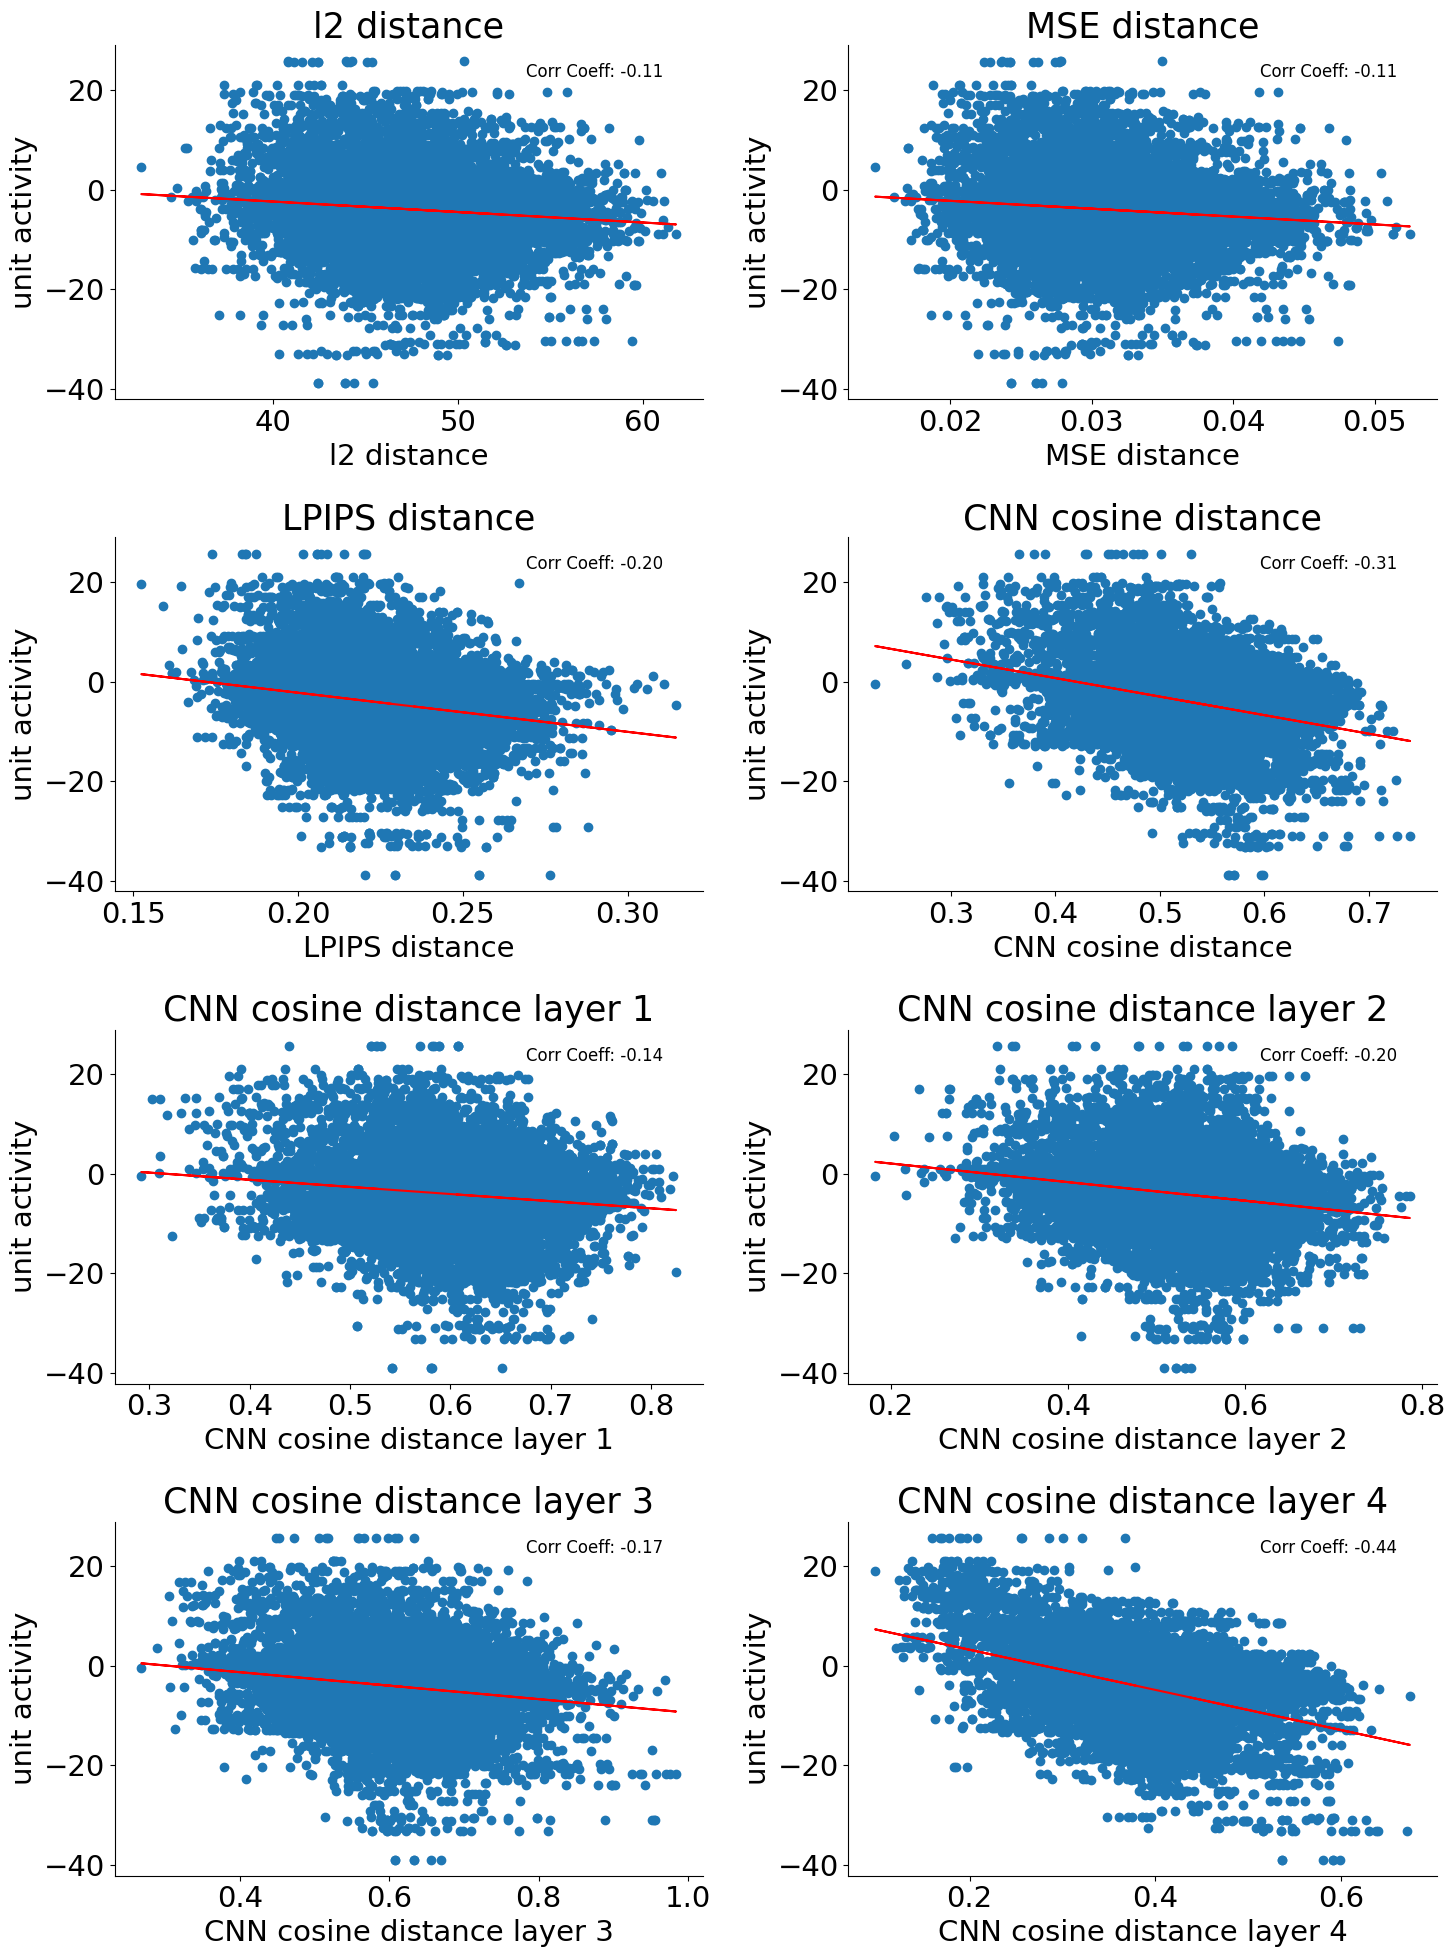

In [31]:

#row_filter = unit_resp_dist_pd['chan_id'] > 0

def plot_madoul(x_clean, y_clean, ax):
    ax.scatter(x_clean, y_clean)
    # Line of best fit
    m1, b1 = np.polyfit(x_clean, y_clean, 1)
    ax.plot(x_clean, m1*x_clean + b1, color='red')  # Add line of best fit
    # Calculate the correlation coefficient
    corr_coeff1 = np.corrcoef(x_clean, y_clean)[0, 1]
    ax.text(.7, 0.95, f'Corr Coeff: {corr_coeff1:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='top')

# First subplot
fig, ax = plt.subplots(4, 2, figsize=(15, 20))
plot_madoul(recon_proto_similarities_l2_cat, unit_act_catb, ax[0, 0])
ax[0, 0].set_title('l2 distance')
ax[0, 0].set_xlabel('l2 distance')
ax[0, 0].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_mse_cat, unit_act_catb, ax[0, 1])
ax[0, 1].set_title('MSE distance')
ax[0, 1].set_xlabel('MSE distance')
ax[0, 1].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_lpips_cat, unit_act_catb, ax[1, 0])
ax[1, 0].set_title('LPIPS distance')
ax[1, 0].set_xlabel('LPIPS distance')
ax[1, 0].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_CNN_cosine_cat, unit_act_catb, ax[1, 1])
ax[1, 1].set_title('CNN cosine distance')
ax[1, 1].set_xlabel('CNN cosine distance')
ax[1, 1].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_CNN_cosine_l1_cat, unit_act_catb, ax[2, 0])
ax[2, 0].set_title('CNN cosine distance layer 1')
ax[2, 0].set_xlabel('CNN cosine distance layer 1')
ax[2, 0].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_CNN_cosine_l2_cat, unit_act_catb, ax[2, 1])
ax[2, 1].set_title('CNN cosine distance layer 2')
ax[2, 1].set_xlabel('CNN cosine distance layer 2')
ax[2, 1].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_CNN_cosine_l3_cat, unit_act_catb, ax[3, 0])
ax[3, 0].set_title('CNN cosine distance layer 3')
ax[3, 0].set_xlabel('CNN cosine distance layer 3')
ax[3, 0].set_ylabel('unit activity')

plot_madoul(recon_proto_similarities_CNN_cosine_l4_cat, unit_act_catb, ax[3, 1])
ax[3, 1].set_title('CNN cosine distance layer 4')
ax[3, 1].set_xlabel('CNN cosine distance layer 4')
ax[3, 1].set_ylabel('unit activity')

plt.tight_layout()
plt.show()




In [ ]:
li = 3
target_proto_similarities = recon_proto_similarities_mat[:, li]
recon_proto_similarities = target_proto_similarities_mat[:, li]

In [ ]:
# let have scatter plot of the similarity of the prototypes to the target image and the activity of the units
# for both the target and the reconstruction
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(target_proto_similarities, unit_act)
ax[0].set_xlabel("similarity of prpto to the target", fontsize=17)
ax[0].set_ylabel("activity of the unit", fontsize=17)
# let add linear regression line 
z = np.polyfit(target_proto_similarities, unit_act, 1)
p = np.poly1d(z)
ax[0].plot(target_proto_similarities,p(target_proto_similarities),"r--")
# add correlation and p value to the title
correlation, p_value = stats.pearsonr(target_proto_similarities, unit_act)
ax[0].set_title(f"correlation = {correlation:.2f}, p = {p_value:.2f}", fontsize=17)

ax[1].scatter(recon_proto_similarities, unit_act)
ax[1].set_xlabel("similarity of prpto to the recon", fontsize=17)
ax[1].set_ylabel("activity of the unit", fontsize=17)
# let add linear regression line
z = np.polyfit(recon_proto_similarities, unit_act, 1)
p = np.poly1d(z)
ax[1].plot(recon_proto_similarities,p(recon_proto_similarities),"r--")
# add correlation and p value to the title
correlation, p_value = stats.pearsonr(recon_proto_similarities, unit_act)
ax[1].set_title(f"correlation = {correlation:.2f}, p = {p_value:.2f}", fontsize=17)

ax[2].scatter(recon_proto_similarities, target_proto_similarities)
ax[2].set_xlabel("similarity of prpto to the recon", fontsize=17)
ax[2].set_ylabel("similarity of prpto to the target", fontsize=17)
# let add linear regression line
z = np.polyfit(recon_proto_similarities, target_proto_similarities, 1)
p = np.poly1d(z)
ax[2].plot(recon_proto_similarities,p(recon_proto_similarities),"r--")
# add correlation and p value to the title
correlation, p_value = stats.pearsonr(recon_proto_similarities, target_proto_similarities)
ax[2].set_title(f"correlation = {correlation:.2f}, p = {p_value:.2f}", fontsize=17)
plt.tight_layout()
plt.show()






In [ ]:
# let use the observer network to get the similarity between the prototypes and the target image
from core.utils.CNN_scorers import TorchScorer
from core.utils.func_lib import *
input_size = (3, 227, 227)

'''net_name = 'resnet50'
layer_list = ['.layer1.2.BatchNorm2dbn3', '.layer2.3.BatchNorm2dbn3', '.layer3.5.BatchNorm2dbn3', '.layer4.2.BatchNorm2dbn3']

net_name = 'resnet50_linf_8'
layer_list = ['.layer1.2.BatchNorm2dbn3', '.layer2.3.BatchNorm2dbn3', '.layer3.5.BatchNorm2dbn3', '.layer4.2.BatchNorm2dbn3']

net_name = 'cornet_s'
layer_list = ['.V1.BatchNorm2dnorm2', '.V2.BatchNorm2dnorm3_1', '.V4.BatchNorm2dnorm3_3', '.IT.BatchNorm2dnorm3_1']
'''
net_name = 'alexnet'
layer_list = ['.features.Conv2d3', '.features.Conv2d6', '.features.Conv2d8', '.features.Conv2d10']
scorer = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
    scorer.model, input_size, "cuda", False)
unit_mask_dict, unit_tsridx_dict = set_all_center_unit_population_recording(
                    scorer, layer_list)

In [ ]:
proto_encoded, _ = encode_image(scorer, proto_tensor_masked,  key=layer_list,
                                    RFresize=False, cat_layes=False)
recon_encoded, _ = encode_image(scorer, recontruction_image_masked.unsqueeze(0),  key=layer_list,
                                    RFresize=False, cat_layes=False)
target_encoded, _ = encode_image(scorer, target_image_masked.unsqueeze(0),  key=layer_list,
                                    RFresize=False, cat_layes=False)


In [ ]:
# let get get the cosine similarity between the prototypes and the recon encoded
from sklearn.metrics.pairwise import cosine_similarity
li = 2
encoding_sim_recon = np.mean(cosine_similarity(proto_encoded[li], recon_encoded[li]), axis=1)
encoding_sim_target = np.mean(cosine_similarity(proto_encoded[li], target_encoded[li]), axis=1)
unit_act = recon_act_mat[num_gen-1, :]
# let get the l2 distance between the prototypes and the target image
set_filter = np.array(proto_gen_rerun_id) == 0
filtered_recon_proto_similarities = encoding_sim_recon[set_filter]
filtered_target_proto_similarities = encoding_sim_target[set_filter]

In [ ]:
# let have scatter plot of the l2 distance between the prototypes and the target image
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(filtered_recon_proto_similarities, filtered_target_proto_similarities)
ax.set_xlabel("similarity of prpto to the recon", fontsize=17)
ax.set_ylabel("similarity of prpto to the target", fontsize=17)
# let add linear regression line
z = np.polyfit(filtered_recon_proto_similarities, filtered_target_proto_similarities, 1)
p = np.poly1d(z)
ax.plot(filtered_recon_proto_similarities,p(filtered_recon_proto_similarities),"r--")
plt.show()

# let have scatter plot of the similarity of the prototypes to the target image and the activity of the units
# for both the target and the reconstruction
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(filtered_target_proto_similarities, unit_act)
ax[0].set_xlabel("similarity of prpto to the target", fontsize=17)
ax[0].set_ylabel("activity of the unit", fontsize=17)
# let add linear regression line 
z = np.polyfit(filtered_target_proto_similarities, unit_act, 1)
p = np.poly1d(z)
ax[0].plot(filtered_target_proto_similarities,p(filtered_target_proto_similarities),"r--")
# add correlation and p value to the title
correlation, p_value = stats.pearsonr(filtered_target_proto_similarities, unit_act)
ax[0].set_title(f"correlation = {correlation:.2f}, p = {p_value:.2f}", fontsize=17)

ax[1].scatter(filtered_recon_proto_similarities, unit_act)
ax[1].set_xlabel("similarity of prpto to the recon", fontsize=17)
ax[1].set_ylabel("activity of the unit", fontsize=17)
# let add linear regression line
z = np.polyfit(filtered_recon_proto_similarities, unit_act, 1)
p = np.poly1d(z)
ax[1].plot(filtered_recon_proto_similarities,p(filtered_recon_proto_similarities),"r--")
# add correlation and p value to the title
correlation, p_value = stats.pearsonr(filtered_recon_proto_similarities, unit_act)
ax[1].set_title(f"correlation = {correlation:.2f}, p = {p_value:.2f}", fontsize=17)
plt.tight_layout()
plt.show()




In [ ]:
scorer.cleanup()
torch.cuda.empty_cache() 